## Импорт необходимых библиотек

In [1]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
from tqdm.notebook import tqdm
import torchvision.transforms as T
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid

import os
import re
import requests

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import random
from sklearn.metrics import classification_report

## Список классов заболеваний + лейблы датасета

In [2]:
classes = ["Nutrient surplus", "Magnesium", "phosphate", "Healthy", "Phosphorous", "nitrates", "potassium", "nitrogen", "calcium", "Sulfur"]
classes_labels = {
        "Nutrient surplus": [0],
        "Magnesium+phosphate": [1, 2],
        "Healthy": [3],
        "Phosphorous+magnesium": [4, 1],
        "nitrates+potassium": [5, 6],
        "nitrogen+potassium": [7, 6],
        "calcium+phosporous": [8, 4],
        "Sulfur+magnesium": [9, 1],
    }
print(len(classes_labels), len(classes))

8 10


## Некоторые вспомогательные функции
* `seed_everything` - функция закрепляющая seed для дальнейшей воспроизводимости экспериментов
* `get_path_names` - функция для парсинга папок датасета
* `encode_label` - функция энкодинга лейблов датасета
* `decode_target` - функция декодинга ответа модели по трешхолду
* `denorm` - функция денормализации тензоров
* `show_example` - функция для отображения элемента датасета 
* `show_batch` - функция для отображения батча изображений

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
# Making a list that contains the paths of each image
def get_path_names(dir):
    images = []
    for path, subdirs, files in os.walk(data_dir):
        for sub in subdirs:
            data_path = os.path.join(path, sub)
            for p, s, f in os.walk(data_path):
                for n in f:
                    images.append(os.path.join(p, n))
    return images

def encode_label(label, classes_list = classes): #encoding the classes into a tensor of shape (10) with 0 and 1s.
    target = torch.zeros(10)
    for l in eval(label):
        target[l] = 1
    return target


def decode_target(target, threshold=0.5): #decoding the prediction tensors of 0s and 1s into text form
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
            result.append(classes[i])     
    return ' '.join(result)

def denorm(img_tensors): #this function will denormalize the tensors 
    return img_tensors * imagenet_stats[1][0] + imagenet_stats[0][0]

def show_example(img,label):
    plt.imshow(denorm(img).permute(1,2,0))
    print("Label:", decode_target(label))
    print()
    print(label)
    
#let's see a batch of images (16 images) in a grid
def show_batch(dl, nmax=16):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(denorm(images[:nmax]), nrow=4).permute(1, 2, 0))
        break

seed_everything(42)

In [4]:
data_dir = "../input/gidtowerdatasetmultilabel/final_cropped_dataset/final_cropped_dataset"
print(os.listdir(data_dir))
print(len(os.listdir(data_dir)))

['nitrogen+potassium', 'Phosphorous+magnesium', 'nitrates+potassium', 'Magnesium+phosphate', 'Nutrient surplus', 'Healthy', 'calcium+phosporous', 'Sulfur+magnesium']
8


## Считывание и преобразование csv файла датасета

In [5]:
df = pd.read_csv("../input/gidtowerdatasetmultilabel/dataset.csv/dataset.csv")
df = df[["imgs", "labels"]]
df

,imgs,labels
0,final_cropped_dataset/Nutrient surplus/63.jpg,[0]
1,final_cropped_dataset/Nutrient surplus/77.jpg,[0]
2,final_cropped_dataset/Nutrient surplus/76.jpg,[0]
3,final_cropped_dataset/Nutrient surplus/62.jpg,[0]
4,final_cropped_dataset/Nutrient surplus/74.jpg,[0]
...,...,...
713,final_cropped_dataset/Sulfur+magnesium/91.jpg,"[9, 1]"
714,final_cropped_dataset/Sulfur+magnesium/85.jpg,"[9, 1]"
715,final_cropped_dataset/Sulfur+magnesium/52.jpg,"[9, 1]"
716,final_cropped_dataset/Sulfur+magnesium/0.jpg,"[9, 1]"


#### В датасете есть сломанное изображение - берем все значения кроме сломанного

In [6]:
df = df[df["imgs"]!="final_cropped_dataset/Sulfur+magnesium/69.jpg"]
df = df.reset_index()
df

,index,imgs,labels
0,0,final_cropped_dataset/Nutrient surplus/63.jpg,[0]
1,1,final_cropped_dataset/Nutrient surplus/77.jpg,[0]
2,2,final_cropped_dataset/Nutrient surplus/76.jpg,[0]
3,3,final_cropped_dataset/Nutrient surplus/62.jpg,[0]
4,4,final_cropped_dataset/Nutrient surplus/74.jpg,[0]
...,...,...,...
712,713,final_cropped_dataset/Sulfur+magnesium/91.jpg,"[9, 1]"
713,714,final_cropped_dataset/Sulfur+magnesium/85.jpg,"[9, 1]"
714,715,final_cropped_dataset/Sulfur+magnesium/52.jpg,"[9, 1]"
715,716,final_cropped_dataset/Sulfur+magnesium/0.jpg,"[9, 1]"


## Кастомный класс датасета

In [7]:
# A class to create a Custom Dataset that will load images and encode the labels of those images from their folder names
class myDataset(Dataset):
    def __init__(self, root_dir, labels, transform=None):
        self.transform = transform
        self.root_dir = root_dir
        self.labels = labels
        self.images = get_path_names(root_dir)              
      

    def __len__(self):
        return len(self.images)       

    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)    
            
        labels = self.labels[idx]
        
        return img, encode_label(labels)   


## Аугментации, которые мы применим к изображениям датасета

In [8]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # mean and std values of the Imagenet Dataset so that pretrained models could also be used


#setting a set of transformations to transform the images 
transform= T.Compose([T.Resize(224),
                      T.RandomCrop(224),
#                       T.RandomHorizontalFlip(),
                      T.RandomVerticalFlip(0.5),
#                       T.RandomRotation(2),
                      T.ToTensor(),
                      T.Normalize(*imagenet_stats)])

In [9]:
#Creating a dataset that loads images from the specified directory, encode their labels and transforming them into tensors.
dataset = myDataset(data_dir, labels=df.labels, transform = transform)
len(dataset)

715

Label: nitrates potassium

tensor([0., 0., 0., 0., 0., 1., 1., 0., 0., 0.])


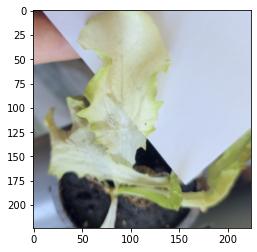

In [10]:
show_example(*dataset[380]) #let's take an example

## Создание train и val выборок датасета

In [11]:
val_percent = int(0.15 * len(dataset)) #setting 15 percent of the total number of images for validation
train_size = len(dataset) - val_percent
val_size = len(dataset) - train_size
train_size, val_size

(608, 107)

In [12]:
train_ds, val_ds = random_split(dataset, [train_size, val_size]) #splitting the dataset for training and validation.
len(train_ds), len(val_ds)

(608, 107)

## Создание Dataloader для использования batch-ей данных при обучении

In [13]:
#setting batch size for Dataloader to load the data batch by batch
batch_size = 16
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size * 2)

### Отображение батча 

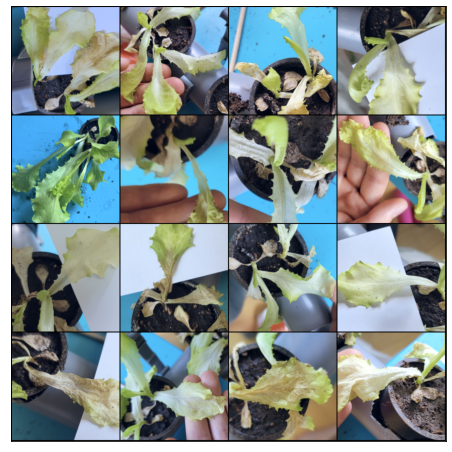

In [14]:
show_batch(train_loader)

## Класс с основными методами для Multilabel моделей

In [15]:
class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        """Get from training batch image and target, then push to model,
        finaly calculate loss
        """
        
        images, targets = batch 
        out = self(images)                            # Generate predictions
        loss = F.binary_cross_entropy(out, targets)   # Calculate loss
        return loss    

    def validation_step(self, batch):
        """Get from val batch image and target, then push to model,
        compute loss and output arrays for metric count
        """
        
        pred_Y = []
        true_Y = []
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.binary_cross_entropy(out, targets)  # Calculate loss
        pred_Y.append(np.array((out.detach().to("cpu") > 0.5).float()))
        true_Y.append(np.array(targets.detach().to("cpu").tolist()))
        return {'val_loss': loss.detach(), "metrics": (np.array(pred_Y), np.array(true_Y))}      


    def validation_epoch_end(self, outputs):
        """Count scores (losses, classification metrics) at the end of val epoch"""
        
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()      # Combine losses and get the mean value
        batch_scores = [x['metrics'] for x in outputs]
        pred_Y = [preds[0] for preds in batch_scores]
        final_preds = np.concatenate(pred_Y, axis=1)[0].tolist()
        true_Y = [preds[1] for preds in batch_scores]
        final_true = np.concatenate(true_Y, axis=1)[0].tolist()
        score = classification_report(final_preds, final_true, target_names=classes)
        print(score)
        return {'val_loss': epoch_loss.item()}    

    def epoch_end(self, epoch, result):                     # display the losses
        print("Epoch [{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss']))

## Вспомогательные функции и класс для размещения необходимого на GPU

In [16]:
#helper functions to load the data and model onto GPU
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu') 


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():  
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device       

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

In [17]:
#loading training and validation data onto GPU
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)

## Вспомогательные метода для обучения 
* `evaluate` - функция с шагом валидации модели
* `fit_one_cycle` - функция с циклом обучения модели (включая подсчет валидационных значений)

In [18]:
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader)) #schedule the learning rate with OneCycleLR

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

## Кастомные классы моделей 

In [19]:
from torch import nn
import torchvision as vision

class ResNet18(MultilabelImageClassificationBase):
    def __init__(self, in_channels, num_classes=10):
        super().__init__()
        self.backbone = vision.models.resnet18(pretrained=True)
        classifier_name, old_classifier = self.backbone._modules.popitem()
        if isinstance(old_classifier, nn.Sequential):
            input_shape = old_classifier[-1].in_features
            old_classifier[-1] = nn.Linear(input_shape,num_classes)

        elif isinstance(old_classifier, nn.Linear):
            input_shape = old_classifier.in_features
            old_classifier = nn.Linear(input_shape,num_classes)
        else:
            raise Exception("Uknown type of classifier {}".format(type(old_classifier)))
        self.backbone.add_module(classifier_name, old_classifier)

    def forward(self, X):
        out = self.backbone(X)
        out = F.sigmoid(out)
        return out

class MobileNetV2(MultilabelImageClassificationBase):
    def __init__(self, in_channels, num_classes=10):
        super().__init__()
        self.backbone = vision.models.mobilenet_v2(pretrained=True)
        classifier_name, old_classifier = self.backbone._modules.popitem()
        if isinstance(old_classifier, nn.Sequential):
            input_shape = old_classifier[-1].in_features
            old_classifier[-1] = nn.Linear(input_shape,num_classes)

        elif isinstance(old_classifier, nn.Linear):
            input_shape = old_classifier.in_features
            old_classifier = nn.Linear(input_shape,num_classes)
        else:
            raise Exception("Uknown type of classifier {}".format(type(old_classifier)))
        self.backbone.add_module(classifier_name, old_classifier)

    def forward(self, X):
        out = self.backbone(X)
        out = F.sigmoid(out)
        return out

In [20]:
model = to_device(MobileNetV2(3, len(classes)), device) #input size: 3, output size: 11, loading model onto GPU

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


## Проверка результатов коробочной (еще не обученной) модели

In [21]:
history = [evaluate(model, val_dl)]
history

                  precision    recall  f1-score   support

Nutrient surplus       1.00      0.06      0.12        77
       Magnesium       0.02      0.50      0.03         2
       phosphate       0.84      0.16      0.28        97
         Healthy       0.62      0.13      0.21        63
     Phosphorous       0.03      0.50      0.06         2
        nitrates       0.00      0.00      0.00         2
       potassium       1.00      0.15      0.26       106
        nitrogen       0.29      0.06      0.10        33
         calcium       0.00      0.00      0.00         0
          Sulfur       0.00      0.00      0.00         0

       micro avg       0.25      0.13      0.17       382
       macro avg       0.38      0.16      0.11       382
    weighted avg       0.82      0.13      0.21       382
     samples avg       0.29      0.13      0.17       382



[{'val_loss': 0.6880977749824524}]

### Параметры для обучения

In [22]:
epochs = 35
max_lr = 0.0001
grad_clip = 0.1
weight_decay = 1e-3
opt_func = torch.optim.Adam

In [23]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         grad_clip=grad_clip,
                         weight_decay=weight_decay,
                         opt_func=opt_func)


                  precision    recall  f1-score   support

Nutrient surplus       0.20      0.05      0.08        20
       Magnesium       0.41      0.56      0.47        41
       phosphate       0.89      0.18      0.30        96
         Healthy       0.23      0.11      0.15        28
     Phosphorous       0.03      1.00      0.06         1
        nitrates       0.11      0.50      0.18         2
       potassium       1.00      0.18      0.30        91
        nitrogen       0.71      0.12      0.21        40
         calcium       0.00      0.00      0.00         1
          Sulfur       0.09      0.29      0.13         7

       micro avg       0.35      0.21      0.26       327
       macro avg       0.37      0.30      0.19       327
    weighted avg       0.71      0.21      0.28       327
     samples avg       0.34      0.20      0.25       327

Epoch [0], last_lr: 0.0000, train_loss: 0.6610, val_loss: 0.6427



                  precision    recall  f1-score   support

Nutrient surplus       0.00      0.00      0.00         5
       Magnesium       0.41      0.55      0.47        42
       phosphate       0.63      0.18      0.28        66
         Healthy       0.00      0.00      0.00         5
     Phosphorous       0.06      1.00      0.12         2
        nitrates       0.00      0.00      0.00         0
       potassium       0.75      0.24      0.37        49
        nitrogen       0.86      0.50      0.63        12
         calcium       0.00      0.00      0.00         0
          Sulfur       0.09      0.50      0.15         4

       micro avg       0.29      0.31      0.30       185
       macro avg       0.28      0.30      0.20       185
    weighted avg       0.58      0.31      0.35       185
     samples avg       0.27      0.27      0.26       185

Epoch [1], last_lr: 0.0000, train_loss: 0.6149, val_loss: 0.5803



                  precision    recall  f1-score   support

Nutrient surplus       0.00      0.00      0.00         1
       Magnesium       0.50      0.64      0.56        44
       phosphate       0.11      0.20      0.14        10
         Healthy       0.00      0.00      0.00         0
     Phosphorous       0.06      1.00      0.12         2
        nitrates       0.00      0.00      0.00         0
       potassium       0.56      1.00      0.72         9
        nitrogen       1.00      1.00      1.00         7
         calcium       0.00      0.00      0.00         0
          Sulfur       0.09      1.00      0.16         2

       micro avg       0.26      0.67      0.37        75
       macro avg       0.23      0.48      0.27        75
    weighted avg       0.47      0.67      0.53        75
     samples avg       0.23      0.35      0.27        75

Epoch [2], last_lr: 0.0000, train_loss: 0.5386, val_loss: 0.4998



                  precision    recall  f1-score   support

Nutrient surplus       0.00      0.00      0.00         0
       Magnesium       0.64      0.63      0.64        57
       phosphate       0.00      0.00      0.00         0
         Healthy       0.00      0.00      0.00         0
     Phosphorous       0.23      0.78      0.35         9
        nitrates       0.00      0.00      0.00         0
       potassium       0.44      1.00      0.61         7
        nitrogen       1.00      1.00      1.00         7
         calcium       0.00      0.00      0.00         0
          Sulfur       0.48      1.00      0.65        11

       micro avg       0.35      0.75      0.47        91
       macro avg       0.28      0.44      0.32        91
    weighted avg       0.59      0.75      0.64        91
     samples avg       0.32      0.46      0.36        91

Epoch [3], last_lr: 0.0000, train_loss: 0.4443, val_loss: 0.4126



                  precision    recall  f1-score   support

Nutrient surplus       0.00      0.00      0.00         0
       Magnesium       0.68      0.68      0.68        56
       phosphate       0.00      0.00      0.00         0
         Healthy       0.00      0.00      0.00         0
     Phosphorous       0.32      0.83      0.47        12
        nitrates       0.00      0.00      0.00         0
       potassium       0.44      1.00      0.61         7
        nitrogen       1.00      1.00      1.00         7
         calcium       0.00      0.00      0.00         0
          Sulfur       0.87      0.80      0.83        25

       micro avg       0.42      0.77      0.54       107
       macro avg       0.33      0.43      0.36       107
    weighted avg       0.69      0.77      0.71       107
     samples avg       0.38      0.50      0.42       107

Epoch [4], last_lr: 0.0000, train_loss: 0.3691, val_loss: 0.3489



                  precision    recall  f1-score   support

Nutrient surplus       0.00      0.00      0.00         0
       Magnesium       0.62      0.70      0.66        50
       phosphate       0.00      0.00      0.00         0
         Healthy       0.00      0.00      0.00         0
     Phosphorous       0.58      0.64      0.61        28
        nitrates       0.00      0.00      0.00         0
       potassium       0.50      1.00      0.67         8
        nitrogen       1.00      1.00      1.00         7
         calcium       0.12      1.00      0.21         2
          Sulfur       0.83      0.95      0.88        20

       micro avg       0.45      0.77      0.57       115
       macro avg       0.36      0.53      0.40       115
    weighted avg       0.65      0.77      0.70       115
     samples avg       0.42      0.56      0.46       115

Epoch [5], last_lr: 0.0001, train_loss: 0.3200, val_loss: 0.3127



                  precision    recall  f1-score   support

Nutrient surplus       0.00      0.00      0.00         0
       Magnesium       0.55      0.72      0.63        43
       phosphate       0.05      1.00      0.10         1
         Healthy       0.00      0.00      0.00         0
     Phosphorous       0.65      0.61      0.62        33
        nitrates       0.44      0.67      0.53         6
       potassium       0.69      0.85      0.76        13
        nitrogen       1.00      1.00      1.00         7
         calcium       0.18      0.60      0.27         5
          Sulfur       0.78      0.95      0.86        19

       micro avg       0.48      0.75      0.59       127
       macro avg       0.43      0.64      0.48       127
    weighted avg       0.63      0.75      0.67       127
     samples avg       0.44      0.56      0.48       127

Epoch [6], last_lr: 0.0001, train_loss: 0.2822, val_loss: 0.3029



                  precision    recall  f1-score   support

Nutrient surplus       0.00      0.00      0.00         0
       Magnesium       0.66      0.71      0.69        52
       phosphate       0.11      0.40      0.17         5
         Healthy       0.00      0.00      0.00         0
     Phosphorous       0.52      0.62      0.56        26
        nitrates       0.33      0.50      0.40         6
       potassium       0.62      0.71      0.67        14
        nitrogen       1.00      1.00      1.00         7
         calcium       0.47      0.89      0.62         9
          Sulfur       0.96      0.88      0.92        25

       micro avg       0.54      0.73      0.62       144
       macro avg       0.47      0.57      0.50       144
    weighted avg       0.65      0.73      0.68       144
     samples avg       0.49      0.58      0.52       144

Epoch [7], last_lr: 0.0001, train_loss: 0.2527, val_loss: 0.2810



                  precision    recall  f1-score   support

Nutrient surplus       0.00      0.00      0.00         0
       Magnesium       0.64      0.72      0.68        50
       phosphate       0.26      0.62      0.37         8
         Healthy       0.00      0.00      0.00         1
     Phosphorous       0.68      0.62      0.65        34
        nitrates       0.44      0.50      0.47         8
       potassium       0.69      0.61      0.65        18
        nitrogen       1.00      1.00      1.00         7
         calcium       0.47      0.67      0.55        12
          Sulfur       0.83      1.00      0.90        19

       micro avg       0.57      0.71      0.63       157
       macro avg       0.50      0.57      0.53       157
    weighted avg       0.65      0.71      0.67       157
     samples avg       0.52      0.59      0.54       157

Epoch [8], last_lr: 0.0001, train_loss: 0.2107, val_loss: 0.2850



                  precision    recall  f1-score   support

Nutrient surplus       0.00      0.00      0.00         0
       Magnesium       0.68      0.79      0.73        48
       phosphate       0.21      0.80      0.33         5
         Healthy       0.00      0.00      0.00         0
     Phosphorous       0.74      0.66      0.70        35
        nitrates       0.56      0.45      0.50        11
       potassium       0.75      0.63      0.69        19
        nitrogen       1.00      1.00      1.00         7
         calcium       0.71      0.80      0.75        15
          Sulfur       0.96      1.00      0.98        22

       micro avg       0.63      0.76      0.69       162
       macro avg       0.56      0.61      0.57       162
    weighted avg       0.73      0.76      0.74       162
     samples avg       0.57      0.63      0.59       162

Epoch [9], last_lr: 0.0001, train_loss: 0.1853, val_loss: 0.2664



                  precision    recall  f1-score   support

Nutrient surplus       0.00      0.00      0.00         0
       Magnesium       0.80      0.74      0.77        61
       phosphate       0.42      0.67      0.52        12
         Healthy       0.08      0.33      0.12         3
     Phosphorous       0.71      0.59      0.65        37
        nitrates       0.44      0.50      0.47         8
       potassium       0.69      0.69      0.69        16
        nitrogen       1.00      1.00      1.00         7
         calcium       0.88      0.79      0.83        19
          Sulfur       0.87      0.87      0.87        23

       micro avg       0.68      0.72      0.70       186
       macro avg       0.59      0.62      0.59       186
    weighted avg       0.75      0.72      0.73       186
     samples avg       0.63      0.67      0.64       186

Epoch [10], last_lr: 0.0001, train_loss: 0.1585, val_loss: 0.2602



                  precision    recall  f1-score   support

Nutrient surplus       0.00      0.00      0.00         1
       Magnesium       0.70      0.68      0.69        57
       phosphate       0.37      0.88      0.52         8
         Healthy       0.23      0.60      0.33         5
     Phosphorous       0.61      0.83      0.70        23
        nitrates       0.44      0.44      0.44         9
       potassium       0.69      0.69      0.69        16
        nitrogen       1.00      1.00      1.00         7
         calcium       0.59      0.83      0.69        12
          Sulfur       0.96      0.96      0.96        23

       micro avg       0.62      0.76      0.68       161
       macro avg       0.56      0.69      0.60       161
    weighted avg       0.68      0.76      0.71       161
     samples avg       0.58      0.62      0.60       161

Epoch [11], last_lr: 0.0001, train_loss: 0.1290, val_loss: 0.2602



                  precision    recall  f1-score   support

Nutrient surplus       0.00      0.00      0.00         1
       Magnesium       0.80      0.70      0.75        64
       phosphate       0.21      0.57      0.31         7
         Healthy       0.08      0.50      0.13         2
     Phosphorous       0.81      0.61      0.69        41
        nitrates       0.44      0.80      0.57         5
       potassium       0.69      0.79      0.73        14
        nitrogen       1.00      1.00      1.00         7
         calcium       0.76      0.76      0.76        17
          Sulfur       0.96      0.96      0.96        23

       micro avg       0.67      0.73      0.70       181
       macro avg       0.58      0.67      0.59       181
    weighted avg       0.77      0.73      0.74       181
     samples avg       0.62      0.66      0.63       181

Epoch [12], last_lr: 0.0001, train_loss: 0.1037, val_loss: 0.2578



                  precision    recall  f1-score   support

Nutrient surplus       0.20      1.00      0.33         1
       Magnesium       0.77      0.72      0.74        60
       phosphate       0.47      0.64      0.55        14
         Healthy       0.00      0.00      0.00         2
     Phosphorous       0.84      0.59      0.69        44
        nitrates       0.44      0.67      0.53         6
       potassium       0.69      1.00      0.81        11
        nitrogen       1.00      1.00      1.00         7
         calcium       0.94      0.89      0.91        18
          Sulfur       0.96      0.96      0.96        23

       micro avg       0.71      0.75      0.73       186
       macro avg       0.63      0.75      0.65       186
    weighted avg       0.78      0.75      0.76       186
     samples avg       0.65      0.69      0.66       186

Epoch [13], last_lr: 0.0001, train_loss: 0.1023, val_loss: 0.2540



                  precision    recall  f1-score   support

Nutrient surplus       0.00      0.00      0.00         2
       Magnesium       0.73      0.72      0.73        57
       phosphate       0.53      0.62      0.57        16
         Healthy       0.46      0.55      0.50        11
     Phosphorous       0.77      0.71      0.74        34
        nitrates       0.56      0.71      0.63         7
       potassium       0.69      0.79      0.73        14
        nitrogen       1.00      1.00      1.00         7
         calcium       0.94      0.84      0.89        19
          Sulfur       1.00      1.00      1.00        23

       micro avg       0.73      0.75      0.74       190
       macro avg       0.67      0.69      0.68       190
    weighted avg       0.75      0.75      0.75       190
     samples avg       0.70      0.72      0.70       190

Epoch [14], last_lr: 0.0001, train_loss: 0.0735, val_loss: 0.2509



                  precision    recall  f1-score   support

Nutrient surplus       0.00      0.00      0.00         2
       Magnesium       0.70      0.75      0.72        52
       phosphate       0.26      0.50      0.34        10
         Healthy       0.38      0.50      0.43        10
     Phosphorous       0.77      0.63      0.70        38
        nitrates       0.44      0.57      0.50         7
       potassium       0.69      0.79      0.73        14
        nitrogen       1.00      1.00      1.00         7
         calcium       0.82      0.78      0.80        18
          Sulfur       1.00      0.92      0.96        25

       micro avg       0.67      0.72      0.70       183
       macro avg       0.61      0.64      0.62       183
    weighted avg       0.72      0.72      0.72       183
     samples avg       0.64      0.66      0.64       183

Epoch [15], last_lr: 0.0001, train_loss: 0.0672, val_loss: 0.2660



                  precision    recall  f1-score   support

Nutrient surplus       0.00      0.00      0.00         2
       Magnesium       0.79      0.79      0.79        56
       phosphate       0.37      0.64      0.47        11
         Healthy       0.38      0.56      0.45         9
     Phosphorous       0.74      0.64      0.69        36
        nitrates       0.44      0.67      0.53         6
       potassium       0.69      0.85      0.76        13
        nitrogen       1.00      1.00      1.00         7
         calcium       0.88      0.79      0.83        19
          Sulfur       1.00      1.00      1.00        23

       micro avg       0.71      0.76      0.74       182
       macro avg       0.63      0.69      0.65       182
    weighted avg       0.75      0.76      0.75       182
     samples avg       0.67      0.69      0.68       182

Epoch [16], last_lr: 0.0001, train_loss: 0.0571, val_loss: 0.2388



                  precision    recall  f1-score   support

Nutrient surplus       0.00      0.00      0.00         1
       Magnesium       0.77      0.72      0.74        60
       phosphate       0.37      0.70      0.48        10
         Healthy       0.23      0.38      0.29         8
     Phosphorous       0.65      0.59      0.62        34
        nitrates       0.56      0.45      0.50        11
       potassium       0.75      0.71      0.73        17
        nitrogen       1.00      1.00      1.00         7
         calcium       0.71      0.80      0.75        15
          Sulfur       0.96      1.00      0.98        22

       micro avg       0.67      0.71      0.69       185
       macro avg       0.60      0.63      0.61       185
    weighted avg       0.71      0.71      0.70       185
     samples avg       0.63      0.67      0.64       185

Epoch [17], last_lr: 0.0001, train_loss: 0.0479, val_loss: 0.2698



                  precision    recall  f1-score   support

Nutrient surplus       0.20      0.33      0.25         3
       Magnesium       0.66      0.73      0.69        51
       phosphate       0.26      0.62      0.37         8
         Healthy       0.46      0.43      0.44        14
     Phosphorous       0.71      0.67      0.69        33
        nitrates       0.56      0.56      0.56         9
       potassium       0.75      0.75      0.75        16
        nitrogen       1.00      1.00      1.00         7
         calcium       0.76      0.81      0.79        16
          Sulfur       1.00      1.00      1.00        23

       micro avg       0.67      0.73      0.70       180
       macro avg       0.64      0.69      0.65       180
    weighted avg       0.70      0.73      0.71       180
     samples avg       0.64      0.68      0.65       180

Epoch [18], last_lr: 0.0001, train_loss: 0.0479, val_loss: 0.2925



                  precision    recall  f1-score   support

Nutrient surplus       0.00      0.00      0.00         2
       Magnesium       0.68      0.69      0.68        55
       phosphate       0.32      0.60      0.41        10
         Healthy       0.23      0.27      0.25        11
     Phosphorous       0.77      0.57      0.66        42
        nitrates       0.44      0.57      0.50         7
       potassium       0.69      0.79      0.73        14
        nitrogen       1.00      1.00      1.00         7
         calcium       0.82      0.74      0.78        19
          Sulfur       0.87      1.00      0.93        20

       micro avg       0.65      0.68      0.66       187
       macro avg       0.58      0.62      0.59       187
    weighted avg       0.69      0.68      0.68       187
     samples avg       0.61      0.64      0.62       187

Epoch [19], last_lr: 0.0001, train_loss: 0.0440, val_loss: 0.3393



                  precision    recall  f1-score   support

Nutrient surplus       0.00      0.00      0.00         2
       Magnesium       0.73      0.72      0.73        57
       phosphate       0.42      0.73      0.53        11
         Healthy       0.23      0.38      0.29         8
     Phosphorous       0.77      0.60      0.68        40
        nitrates       0.44      0.57      0.50         7
       potassium       0.69      0.79      0.73        14
        nitrogen       1.00      1.00      1.00         7
         calcium       0.88      0.83      0.86        18
          Sulfur       1.00      1.00      1.00        23

       micro avg       0.69      0.73      0.71       187
       macro avg       0.62      0.66      0.63       187
    weighted avg       0.74      0.73      0.73       187
     samples avg       0.65      0.67      0.66       187

Epoch [20], last_lr: 0.0001, train_loss: 0.0367, val_loss: 0.2894



                  precision    recall  f1-score   support

Nutrient surplus       0.20      0.33      0.25         3
       Magnesium       0.68      0.78      0.72        49
       phosphate       0.37      0.64      0.47        11
         Healthy       0.31      0.44      0.36         9
     Phosphorous       0.71      0.59      0.65        37
        nitrates       0.44      0.44      0.44         9
       potassium       0.69      0.73      0.71        15
        nitrogen       1.00      1.00      1.00         7
         calcium       0.82      0.74      0.78        19
          Sulfur       0.96      0.96      0.96        23

       micro avg       0.66      0.71      0.69       182
       macro avg       0.62      0.67      0.63       182
    weighted avg       0.69      0.71      0.70       182
     samples avg       0.63      0.66      0.64       182

Epoch [21], last_lr: 0.0001, train_loss: 0.0301, val_loss: 0.3274



                  precision    recall  f1-score   support

Nutrient surplus       0.00      0.00      0.00         2
       Magnesium       0.77      0.72      0.74        60
       phosphate       0.32      0.60      0.41        10
         Healthy       0.31      0.50      0.38         8
     Phosphorous       0.81      0.62      0.70        40
        nitrates       0.44      0.50      0.47         8
       potassium       0.69      0.79      0.73        14
        nitrogen       1.00      1.00      1.00         7
         calcium       0.82      0.74      0.78        19
          Sulfur       1.00      0.96      0.98        24

       micro avg       0.70      0.71      0.71       192
       macro avg       0.62      0.64      0.62       192
    weighted avg       0.75      0.71      0.72       192
     samples avg       0.66      0.68      0.66       192

Epoch [22], last_lr: 0.0000, train_loss: 0.0270, val_loss: 0.3091



                  precision    recall  f1-score   support

Nutrient surplus       0.20      0.33      0.25         3
       Magnesium       0.73      0.77      0.75        53
       phosphate       0.32      0.60      0.41        10
         Healthy       0.38      0.45      0.42        11
     Phosphorous       0.74      0.61      0.67        38
        nitrates       0.44      0.50      0.47         8
       potassium       0.69      0.73      0.71        15
        nitrogen       1.00      1.00      1.00         7
         calcium       0.94      0.84      0.89        19
          Sulfur       1.00      0.96      0.98        24

       micro avg       0.70      0.73      0.71       188
       macro avg       0.64      0.68      0.65       188
    weighted avg       0.73      0.73      0.73       188
     samples avg       0.67      0.68      0.67       188

Epoch [23], last_lr: 0.0000, train_loss: 0.0297, val_loss: 0.3061



                  precision    recall  f1-score   support

Nutrient surplus       0.20      0.33      0.25         3
       Magnesium       0.75      0.71      0.73        59
       phosphate       0.42      0.57      0.48        14
         Healthy       0.23      0.38      0.29         8
     Phosphorous       0.68      0.68      0.68        31
        nitrates       0.44      0.50      0.47         8
       potassium       0.69      0.79      0.73        14
        nitrogen       1.00      1.00      1.00         7
         calcium       0.82      0.88      0.85        16
          Sulfur       1.00      0.92      0.96        25

       micro avg       0.68      0.72      0.70       185
       macro avg       0.62      0.67      0.64       185
    weighted avg       0.71      0.72      0.72       185
     samples avg       0.64      0.67      0.65       185

Epoch [24], last_lr: 0.0000, train_loss: 0.0276, val_loss: 0.2857



                  precision    recall  f1-score   support

Nutrient surplus       0.00      0.00      0.00         1
       Magnesium       0.82      0.75      0.79        61
       phosphate       0.32      0.67      0.43         9
         Healthy       0.46      0.55      0.50        11
     Phosphorous       0.71      0.61      0.66        36
        nitrates       0.44      0.57      0.50         7
       potassium       0.69      0.73      0.71        15
        nitrogen       1.00      1.00      1.00         7
         calcium       0.71      0.75      0.73        16
          Sulfur       0.96      1.00      0.98        22

       micro avg       0.69      0.74      0.71       185
       macro avg       0.61      0.66      0.63       185
    weighted avg       0.74      0.74      0.73       185
     samples avg       0.66      0.69      0.67       185

Epoch [25], last_lr: 0.0000, train_loss: 0.0268, val_loss: 0.2869



                  precision    recall  f1-score   support

Nutrient surplus       0.00      0.00      0.00         1
       Magnesium       0.77      0.72      0.74        60
       phosphate       0.37      0.70      0.48        10
         Healthy       0.31      0.50      0.38         8
     Phosphorous       0.74      0.57      0.65        40
        nitrates       0.44      0.50      0.47         8
       potassium       0.69      0.73      0.71        15
        nitrogen       1.00      1.00      1.00         7
         calcium       0.88      0.71      0.79        21
          Sulfur       0.96      1.00      0.98        22

       micro avg       0.69      0.71      0.70       192
       macro avg       0.62      0.64      0.62       192
    weighted avg       0.74      0.71      0.72       192
     samples avg       0.65      0.67      0.66       192

Epoch [26], last_lr: 0.0000, train_loss: 0.0262, val_loss: 0.2917



                  precision    recall  f1-score   support

Nutrient surplus       0.00      0.00      0.00         2
       Magnesium       0.75      0.75      0.75        56
       phosphate       0.32      0.67      0.43         9
         Healthy       0.46      0.55      0.50        11
     Phosphorous       0.77      0.59      0.67        41
        nitrates       0.56      0.62      0.59         8
       potassium       0.69      0.79      0.73        14
        nitrogen       1.00      1.00      1.00         7
         calcium       0.82      0.74      0.78        19
          Sulfur       0.91      1.00      0.95        21

       micro avg       0.69      0.72      0.71       188
       macro avg       0.63      0.67      0.64       188
    weighted avg       0.73      0.72      0.72       188
     samples avg       0.66      0.69      0.67       188

Epoch [27], last_lr: 0.0000, train_loss: 0.0196, val_loss: 0.3198



                  precision    recall  f1-score   support

Nutrient surplus       0.40      0.50      0.44         4
       Magnesium       0.70      0.78      0.74        50
       phosphate       0.32      0.67      0.43         9
         Healthy       0.38      0.38      0.38        13
     Phosphorous       0.74      0.61      0.67        38
        nitrates       0.56      0.62      0.59         8
       potassium       0.75      0.80      0.77        15
        nitrogen       1.00      1.00      1.00         7
         calcium       0.88      0.65      0.75        23
          Sulfur       0.96      0.96      0.96        23

       micro avg       0.69      0.72      0.70       190
       macro avg       0.67      0.70      0.67       190
    weighted avg       0.72      0.72      0.71       190
     samples avg       0.67      0.67      0.66       190

Epoch [28], last_lr: 0.0000, train_loss: 0.0189, val_loss: 0.3096



                  precision    recall  f1-score   support

Nutrient surplus       0.20      0.33      0.25         3
       Magnesium       0.77      0.72      0.74        60
       phosphate       0.42      0.67      0.52        12
         Healthy       0.38      0.36      0.37        14
     Phosphorous       0.74      0.68      0.71        34
        nitrates       0.44      0.57      0.50         7
       potassium       0.69      0.79      0.73        14
        nitrogen       1.00      1.00      1.00         7
         calcium       0.88      0.88      0.88        17
          Sulfur       1.00      1.00      1.00        23

       micro avg       0.71      0.73      0.72       191
       macro avg       0.65      0.70      0.67       191
    weighted avg       0.73      0.73      0.73       191
     samples avg       0.68      0.69      0.68       191

Epoch [29], last_lr: 0.0000, train_loss: 0.0198, val_loss: 0.2929



                  precision    recall  f1-score   support

Nutrient surplus       0.20      0.33      0.25         3
       Magnesium       0.68      0.72      0.70        53
       phosphate       0.42      0.73      0.53        11
         Healthy       0.38      0.50      0.43        10
     Phosphorous       0.77      0.65      0.71        37
        nitrates       0.44      0.57      0.50         7
       potassium       0.69      0.73      0.71        15
        nitrogen       1.00      1.00      1.00         7
         calcium       0.76      0.72      0.74        18
          Sulfur       0.96      1.00      0.98        22

       micro avg       0.68      0.73      0.70       183
       macro avg       0.63      0.70      0.66       183
    weighted avg       0.70      0.73      0.71       183
     samples avg       0.65      0.67      0.66       183

Epoch [30], last_lr: 0.0000, train_loss: 0.0182, val_loss: 0.2982



                  precision    recall  f1-score   support

Nutrient surplus       0.00      0.00      0.00         2
       Magnesium       0.79      0.76      0.77        58
       phosphate       0.42      0.57      0.48        14
         Healthy       0.31      0.44      0.36         9
     Phosphorous       0.74      0.66      0.70        35
        nitrates       0.44      0.50      0.47         8
       potassium       0.69      0.73      0.71        15
        nitrogen       1.00      1.00      1.00         7
         calcium       0.76      0.76      0.76        17
          Sulfur       1.00      0.96      0.98        24

       micro avg       0.70      0.72      0.71       189
       macro avg       0.62      0.64      0.62       189
    weighted avg       0.73      0.72      0.73       189
     samples avg       0.66      0.67      0.66       189

Epoch [31], last_lr: 0.0000, train_loss: 0.0175, val_loss: 0.2893



                  precision    recall  f1-score   support

Nutrient surplus       0.20      0.25      0.22         4
       Magnesium       0.71      0.77      0.74        52
       phosphate       0.37      0.70      0.48        10
         Healthy       0.38      0.45      0.42        11
     Phosphorous       0.81      0.58      0.68        43
        nitrates       0.44      0.44      0.44         9
       potassium       0.69      0.65      0.67        17
        nitrogen       1.00      1.00      1.00         7
         calcium       0.82      0.78      0.80        18
          Sulfur       0.91      1.00      0.95        21

       micro avg       0.69      0.70      0.70       192
       macro avg       0.63      0.66      0.64       192
    weighted avg       0.71      0.70      0.70       192
     samples avg       0.66      0.67      0.66       192

Epoch [32], last_lr: 0.0000, train_loss: 0.0189, val_loss: 0.2870



                  precision    recall  f1-score   support

Nutrient surplus       0.20      0.25      0.22         4
       Magnesium       0.77      0.74      0.75        58
       phosphate       0.37      0.70      0.48        10
         Healthy       0.23      0.38      0.29         8
     Phosphorous       0.81      0.66      0.72        38
        nitrates       0.44      0.57      0.50         7
       potassium       0.69      0.79      0.73        14
        nitrogen       1.00      1.00      1.00         7
         calcium       0.94      0.89      0.91        18
          Sulfur       1.00      1.00      1.00        23

       micro avg       0.71      0.75      0.73       187
       macro avg       0.64      0.70      0.66       187
    weighted avg       0.76      0.75      0.75       187
     samples avg       0.67      0.69      0.68       187

Epoch [33], last_lr: 0.0000, train_loss: 0.0160, val_loss: 0.2902



                  precision    recall  f1-score   support

Nutrient surplus       0.20      0.33      0.25         3
       Magnesium       0.71      0.77      0.74        52
       phosphate       0.37      0.70      0.48        10
         Healthy       0.38      0.50      0.43        10
     Phosphorous       0.74      0.68      0.71        34
        nitrates       0.44      0.57      0.50         7
       potassium       0.69      0.79      0.73        14
        nitrogen       1.00      1.00      1.00         7
         calcium       0.94      0.76      0.84        21
          Sulfur       0.91      1.00      0.95        21

       micro avg       0.69      0.75      0.72       179
       macro avg       0.64      0.71      0.66       179
    weighted avg       0.72      0.75      0.73       179
     samples avg       0.66      0.69      0.67       179

Epoch [34], last_lr: 0.0000, train_loss: 0.0182, val_loss: 0.2847
CPU times: user 22min 44s, sys: 23.9 s, total: 23min 8s
Wall

## Сохранение модели
- В обычном .pth формате 
- В формате torchscript (конвертация модели)

In [24]:
torch.save(model.state_dict(), "classif_model.pth")
net = torch.jit.script(model)
net.save("jit_model.pt")
model_jit = torch.load("jit_model.pt")

## Отображение результатов обучения в виде графиков

### Отображение Loss-а

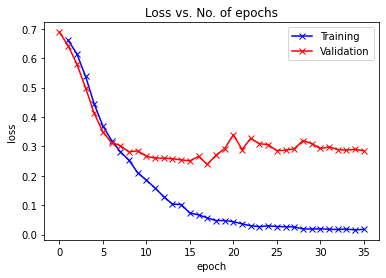

In [25]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
plot_losses(history)

### Отображение learning rate

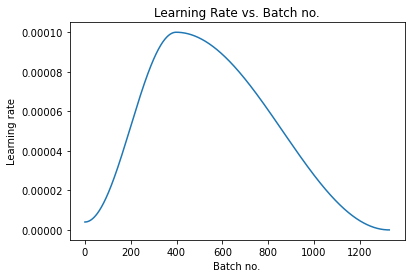

In [26]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
plot_lrs(history)

## Ручная проверка результатов обученной модели 

Label: Healthy

tensor([0.0150, 0.3446, 0.0052, 0.7654, 0.1000, 0.0118, 0.0041, 0.0026, 0.0062,
        0.0414], device='cuda:0', grad_fn=<SelectBackward>)


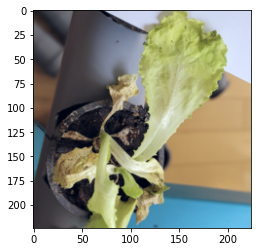

In [27]:
def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model_jit(xb)
    prediction = preds[0]
    show_example(image, prediction)
predict_single(val_ds[20][0]) #checking out the predictions of some images from the validation dataset.

Label: potassium nitrogen

tensor([0.0114, 0.0035, 0.0047, 0.0019, 0.0021, 0.0039, 0.9944, 0.9936, 0.0045,
        0.0069], device='cuda:0', grad_fn=<SelectBackward>)


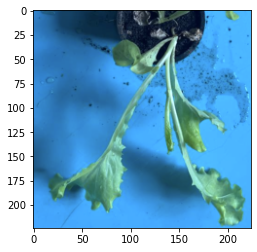

In [28]:
predict_single(val_ds[45][0])

Label: Magnesium Sulfur

tensor([0.0025, 0.9978, 0.0028, 0.0016, 0.0018, 0.0073, 0.0069, 0.0050, 0.0021,
        0.9984], device='cuda:0', grad_fn=<SelectBackward>)


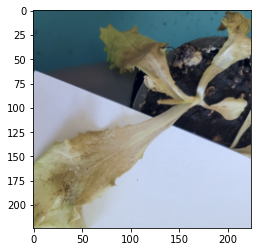

In [29]:
predict_single(val_ds[100][0])

Label: Phosphorous calcium

tensor([0.0255, 0.0163, 0.0111, 0.0154, 0.9711, 0.0292, 0.0319, 0.0104, 0.9598,
        0.0032], device='cuda:0', grad_fn=<SelectBackward>)


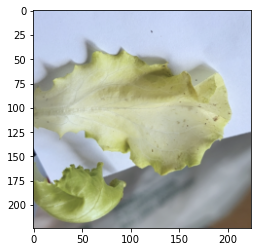

In [30]:
predict_single(val_ds[70][0])